# Модуль 2. Классификация изображений


## Сопоставление изображений


### Алгоритмы сопоставления изображений

Для реализации алгоритма классификации изображений, я предложу вам пример кода, использующий библиотеку tensorflow и keras. В этом примере мы будем использовать предварительно обученную модель MobileNetV2 для классификации изображений.

Прежде всего, убедитесь, что у вас установлены tensorflow и keras


In [2]:
!nvidia-smi

Wed Sep 24 13:25:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.10              Driver Version: 581.29         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5080 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   45C    P8             12W /  130W |   13861MiB /  16303MiB |     15%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import urllib.request

# Загрузка предобученной модели MobileNetV2
model = models.mobilenet_v2(pretrained=True)
model.eval()  # Переключение в режим инференса

# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Используется устройство: {device}")

# Преобразования для входного изображения
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Изменение размера
    transforms.ToTensor(),                  # Конвертация в тензор
    transforms.Normalize(                   # Нормализация (значения ImageNet)
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

def get_imagenet_labels():
    """Загружает или возвращает метки классов ImageNet"""
    filename = "imagenet_classes.txt"
    
    # Если файл не существует, загружаем его
    if not os.path.exists(filename):
        print(f"Файл {filename} не найден. Загрузка...")
        url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        try:
            urllib.request.urlretrieve(url, filename)
            print(f"Файл сохранён в {os.path.abspath(filename)}")
        except Exception as e:
            raise RuntimeError(f"Не удалось загрузить файл: {e}")
    
    # Чтение меток
    with open(filename, "r", encoding="utf-8") as f:
        return [line.strip() for line in f.readlines()]

# Получение меток классов
labels = get_imagenet_labels()

def classify_image(img_path):
    # Загрузка изображения
    img = Image.open(img_path).convert('RGB')
    
    # Применение преобразований
    img_tensor = transform(img).unsqueeze(0).to(device)  # Добавление батча и перемещение на GPU
    
    # Получение предсказания
    with torch.no_grad():  # Отключение вычисления градиентов
        output = model(img_tensor)
    
    # Декодирование результатов
    _, predicted_idx = output.cpu().max(1)  # Получение индекса максимальной вероятности
    predicted_label = labels[predicted_idx.item()]
    return predicted_label

# Пример использования
project_dir = "/root/projects/study_projects/MUIV/cv_course"
img_path = f"{project_dir}/data/samples/texture_01.jpg"

try:
    result = classify_image(img_path)
    print(f"Предсказанный класс: {result}")
except Exception as e:
    print(f"Ошибка: {e}")



Используется устройство: cuda
Файл imagenet_classes.txt не найден. Загрузка...
Файл сохранён в /mnt/g/Мой диск/МУИВ/Преподавание/2025-26/cv_course/seminars/module02/imagenet_classes.txt
Предсказанный класс: tiger


### Построение мозаики из изображений

Для построения мозаики изображений на Python, можно использовать библиотеку PIL (Python Imaging Library), которая теперь доступна как Pillow. Ниже приведен пример кода, который создает мозаику из нескольких изображений. Допустим, у нас есть четыре изображения, и мы хотим их объединить в одно большое изображение-мозаику в формате 2x2.

Прежде всего, убедитесь, что у вас установлена библиотека Pillow


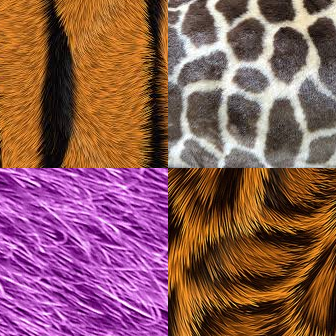

In [8]:
from PIL import Image


def crop_to_square(img, size):
    """
    Обрезка изображения до квадратной формы по центру.
    """
    # Определение текущих размеров
    width, height = img.size

    # Определение размера для обрезки
    new_size = min(width, height, size)

    # Вычисление координат для обрезки
    left = (width - new_size) / 2
    top = (height - new_size) / 2
    right = (width + new_size) / 2
    bottom = (height + new_size) / 2

    # Обрезка и возврат изображения
    img = img.crop((left, top, right, bottom))
    return img.resize((size, size), Image.Resampling.LANCZOS)

project_dir = "/root/projects/study_projects/MUIV/cv_course"

# Пути к изображениям, которые будут включены в мозаику
image_paths = ["image1.jpg", "image2.jpg", "image3.jpg", "image4.jpg"]

# Открытие изображений и их сохранение в список
images = [Image.open(f"{project_dir}/data/samples/{x}") for x in image_paths]

# Определение минимального размера среди всех изображений
min_size = min(min(img.size) for img in images)

# Обрезка изображений до квадратов и изменение их размера
squared_images = [crop_to_square(img, min_size) for img in images]

# Создание нового пустого изображения для мозаики
mosaic_size = (min_size * 2, min_size * 2)
mosaic_image = Image.new("RGB", mosaic_size, (255, 255, 255))

# Размещение изображений в мозаике
positions = [(0, 0), (min_size, 0), (0, min_size), (min_size, min_size)]
for img, pos in zip(squared_images, positions):
    mosaic_image.paste(img, pos)

# Сохранение и показ мозаики
mosaic_image.save(f"{project_dir}/data/result/mosaic.jpg")
mosaic_image.show()

### Построение панорамных изображений


In [15]:
import cv2
import numpy as np


def create_panorama(image1_path, image2_path, output_path="panorama.jpg"):
    # Загружаем изображения
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    # Инициализируем ORB детектор
    orb = cv2.ORB_create()

    # Находим ключевые точки и дескрипторы с помощью ORB
    keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

    # Создаем объект BFMatcher и совершаем сопоставление дескрипторов
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Сортируем сопоставления по расстоянию (лучшие сопоставления первые)
    matches = sorted(matches, key=lambda x: x.distance)

    # Извлекаем координаты соответствующих ключевых точек для сопоставленных дескрипторов
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Находим матрицу гомографии
    H, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Применяем преобразование гомографии к изображению 1
    height, width, channels = image2.shape
    panorama = cv2.warpPerspective(image1, H, (width * 2, height))

    # Копируем изображение 2 в панорамное изображение
    panorama[0 : image2.shape[0], 0 : image2.shape[1]] = image2

    # Сохраняем панорамное изображение
    cv2.imwrite(output_path, panorama)

project_dir = "/root/projects/study_projects/MUIV/cv_course"
# Пример использования:
create_panorama(f"{project_dir}/data/samples/panorama02.jpg", f"{project_dir}/data/samples/panorama01.jpg", f"{project_dir}/data/result/output_panorama.jpg")

## Распознавание лиц


Найдено лиц: 1


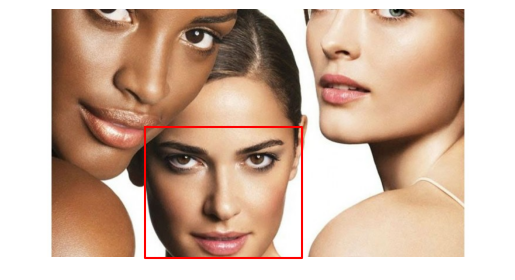

In [16]:
import face_recognition
import matplotlib.pyplot as plt

face = ["3faces.jpg", "manyfaces.jpg"]
# Загрузка изображения
project_dir = "/root/projects/study_projects/MUIV/cv_course"
image_path = f"{project_dir}/data/faces/{face[0]}"
image = face_recognition.load_image_file(image_path)

# Нахождение лиц на изображении
face_locations = face_recognition.face_locations(image)

# Вывод результатов
print(f"Найдено лиц: {len(face_locations)}")
plt.imshow(image)
for face_location in face_locations:
    top, right, bottom, left = face_location
    plt.plot([left, right, right, left, left], [top, top, bottom, bottom, top], "r-")
plt.axis("off")
plt.show()

In [17]:
from PIL import Image
import os


def resize_image(input_image_path, output_image_path, target_size):
    with Image.open(input_image_path) as image:
        original_width, original_height = image.size
        max_dimension = max(original_width, original_height)
        scale = target_size / max_dimension
        new_width = int(original_width * scale)
        new_height = int(original_height * scale)

        resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
        resized_image.save(output_image_path)


def process_images_folder(input_folder, output_folder, target_size):
    # Получение абсолютных путей папок
    script_dir = os.getcwd()
    abs_input_folder = os.path.join(script_dir, input_folder)
    abs_output_folder = os.path.join(script_dir, output_folder)

    if not os.path.exists(abs_output_folder):
        os.makedirs(abs_output_folder)

    for filename in os.listdir(abs_input_folder):
        input_image_path = os.path.join(abs_input_folder, filename)
        if os.path.isfile(input_image_path):
            output_image_path = os.path.join(abs_output_folder, filename)
            try:
                resize_image(input_image_path, output_image_path, target_size)
                print(f"Image {filename} resized and saved to {output_folder}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")


# Пути к папкам относительно скрипта
input_folder = f"{project_dir}/data/plibrary/src"
output_folder = f"{project_dir}/data/plibrary/resampled"
target_size = 800  # Целевой размер для большей стороны изображения

# Обработка всех изображений в папке
process_images_folder(input_folder, output_folder, target_size)

Image img_25.jpg resized and saved to /root/projects/study_projects/MUIV/cv_course/data/plibrary/resampled
Image img_23.jpg resized and saved to /root/projects/study_projects/MUIV/cv_course/data/plibrary/resampled
Image img_24.jpg resized and saved to /root/projects/study_projects/MUIV/cv_course/data/plibrary/resampled
Image img_10.jpg resized and saved to /root/projects/study_projects/MUIV/cv_course/data/plibrary/resampled
Image img_08.jpg resized and saved to /root/projects/study_projects/MUIV/cv_course/data/plibrary/resampled
Image img_09.jpg resized and saved to /root/projects/study_projects/MUIV/cv_course/data/plibrary/resampled
Image img_19.jpg resized and saved to /root/projects/study_projects/MUIV/cv_course/data/plibrary/resampled
Image img_22.jpg resized and saved to /root/projects/study_projects/MUIV/cv_course/data/plibrary/resampled
Image img_12.jpg resized and saved to /root/projects/study_projects/MUIV/cv_course/data/plibrary/resampled
Image img_05.jpg resized and saved to

In [18]:
import face_recognition
import os
from shutil import copy2


def filter_images_with_faces(source_folder, destination_folder):
    # Создание папки назначения, если она не существует
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Перебор всех файлов в исходной папке
    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)

        # Убедитесь, что это файл и он имеет расширение изображения
        if os.path.isfile(file_path) and filename.lower().endswith((".png", ".jpg", ".jpeg")):
            try:
                # Загрузка изображения и поиск лиц
                image = face_recognition.load_image_file(file_path)
                face_locations = face_recognition.face_locations(image)

                # Если лица обнаружены, копировать файл в папку назначения
                if len(face_locations) > 0:
                    destination_path = os.path.join(destination_folder, filename)
                    copy2(file_path, destination_path)
                    print(f"Image {filename} has faces and was copied.")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")


# Задайте пути к папкам
script_dir = os.getcwd()
source_folder = os.path.join(script_dir, f"{project_dir}/data/plibrary/resampled")
destination_folder = os.path.join(script_dir, f"{project_dir}/data/plibrary/justfaces")

# Фильтрация изображений
filter_images_with_faces(source_folder, destination_folder)

Image img_23.jpg has faces and was copied.
Image img_24.jpg has faces and was copied.
Image img_10.jpg has faces and was copied.
Image img_09.jpg has faces and was copied.
Image img_22.jpg has faces and was copied.
Image img_16.jpg has faces and was copied.
Image img_06.jpg has faces and was copied.
Image img_07.jpg has faces and was copied.


In [19]:
import face_recognition
import os
import shutil


def create_directory_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


def find_face_encodings(image_path):
    image = face_recognition.load_image_file(image_path)
    return face_recognition.face_encodings(image)


def are_faces_same(face_encoding, known_faces):
    # Если нет известных лиц, не сравниваем
    if len(known_faces) == 0:
        return -1
    distances = face_recognition.face_distance(known_faces, face_encoding)
    best_match_index = distances.argmin()
    if distances[best_match_index] < 0.6:
        return best_match_index
    else:
        return -1


source_folder = os.path.join(script_dir, f"{project_dir}/data/plibrary/justfaces")
destination_folder = os.path.join(script_dir, f"{project_dir}/data/plibrary/grouped")
create_directory_if_not_exists(destination_folder)

known_faces = []
face_folders = []

# Перебор всех файлов в исходной папке
for filename in os.listdir(source_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(source_folder, filename)
        image_encodings = find_face_encodings(image_path)

        for encoding in image_encodings:
            match_index = are_faces_same(encoding, known_faces)

            if match_index != -1:
                # Лицо совпадает с известным, копируем в соответствующую папку
                shutil.copy2(image_path, face_folders[match_index])
            else:
                # Новое лицо, создаем для него папку
                new_folder_path = os.path.join(destination_folder, f"person_{len(known_faces)}")
                create_directory_if_not_exists(new_folder_path)
                shutil.copy2(image_path, new_folder_path)

                # Добавляем лицо и папку в известные
                known_faces.append(encoding)
                face_folders.append(new_folder_path)

print(f"Фотографии были сгруппированы по {len(known_faces)} лицам.")

Фотографии были сгруппированы по 4 лицам.


## Коллекции для обучения


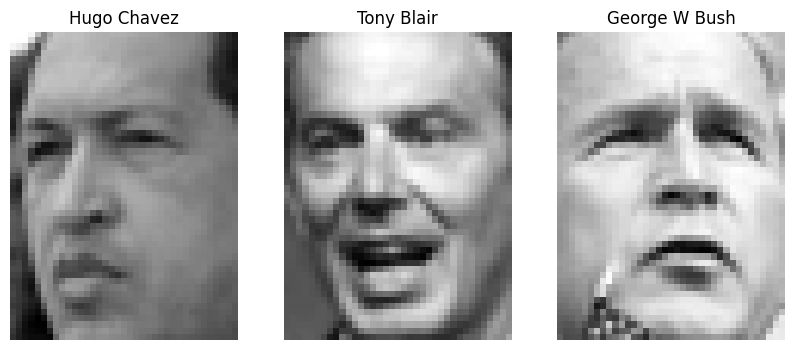

In [20]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt

# Загрузка набора данных LFW
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Получение ссылок на изображения и их метки
images = lfw_people.images
target_names = lfw_people.target_names
targets = lfw_people.target

# Отображение первых 3 изображений
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    ax[i].imshow(images[i], cmap="gray")
    ax[i].set_title(target_names[targets[i]])
    ax[i].axis("off")
plt.show()

## Квантование многомерных признаков

КМП - это процесс преобразования непрерывных или многомерных признаков в дискретные значения, часто используемый для уменьшения количества различных признаков и упрощения алгоритмов машинного обучения, в том числе в контексте классификации изображений и поиска похожих изображений.

В контексте классификации изображений и поиска похожих изображений, одним из распространенных подходов является использование векторов признаков, извлеченных из изображений с помощью предварительно обученных моделей глубокого обучения (например, сетей на основе архитектуры CNN). Квантование этих векторов признаков позволяет сократить объем хранимых данных и ускорить процесс сравнения изображений.

В качестве примера, давайте рассмотрим использование предварительно обученной модели CNN для извлечения признаков из изображений и их последующее квантование с помощью алгоритма K-средних (K-means). Затем мы можем использовать эти квантованные признаки для поиска похожих изображений.


/root/.venv/cv_course/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.venv/cv_course/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Кластер 0 (4 изображений):


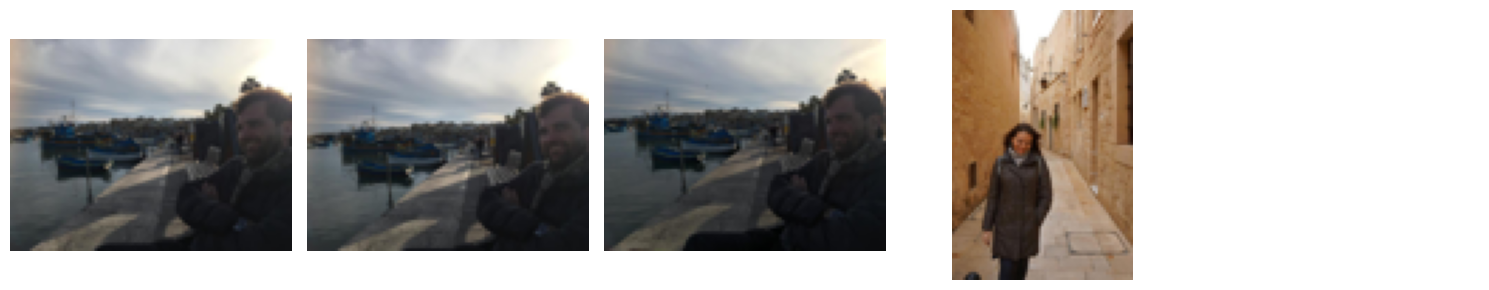


Кластер 2 (3 изображений):


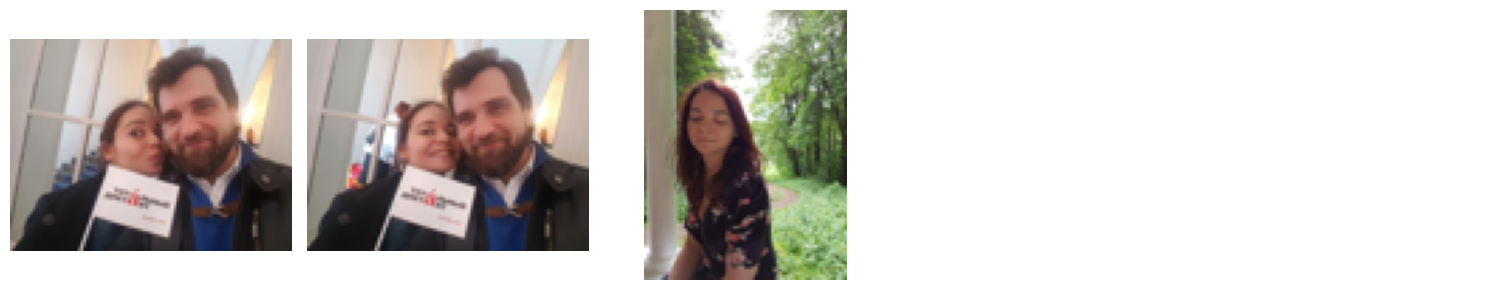


Кластер 1 (1 изображений):


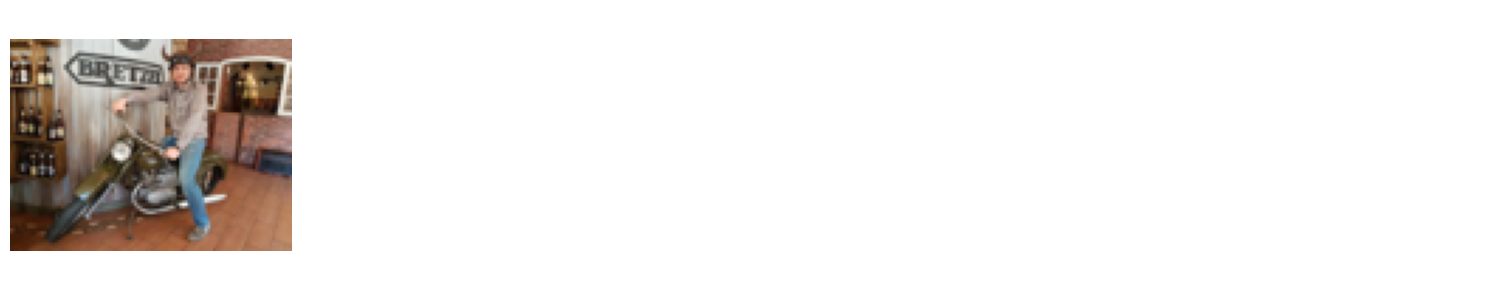

In [26]:
import os
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Настройка модели ---
model = models.resnet50(pretrained=True)
features_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # Удаление финального слоя
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
features_extractor.to(device)
features_extractor.eval()

# --- Преобразования для изображений ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Извлечение признаков ---
def extract_features(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        features = features_extractor(img_tensor)
    return features.cpu().numpy().flatten()

# --- Обработка папки ---
def get_features_from_folder(folder_path):
    features_list = []
    image_paths = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(folder_path, filename)
            try:
                features = extract_features(path)
                features_list.append(features)
                image_paths.append(path)
            except Exception as e:
                print(f"Ошибка при обработке {path}: {e}")
    return np.array(features_list), image_paths

# --- Кластеризация ---
folder_path =  f"{project_dir}/data/plibrary/justfaces"  # Путь к вашей папке с изображениями
features, image_paths = get_features_from_folder(folder_path)
if len(features) == 0:
    raise ValueError("Нет извлеченных признаков для кластеризации")

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(features)
labels = kmeans.labels_

# --- Группировка по кластерам ---
clustered_images = {}
for idx, label in enumerate(labels):
    clustered_images.setdefault(label, []).append(image_paths[idx])

# --- Отображение результатов ---
def create_thumbnail(image_path, size=(100, 100)):
    with Image.open(image_path) as img:
        img.thumbnail(size)
        return img

def display_clustered_images(clustered_images, images_per_row=5):
    for cluster_id, images in clustered_images.items():
        print(f"\nКластер {cluster_id} ({len(images)} изображений):")
        num_rows = (len(images) + images_per_row - 1) // images_per_row
        fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row*3, num_rows*3))
        
        # Приводим axes к 1D-массиву для удобства
        axes_flat = axes.ravel() if num_rows > 1 or images_per_row > 1 else [axes]
        
        for ax, img_path in zip(axes_flat, images):
            thumbnail = create_thumbnail(img_path)
            # Преобразуем PIL.Image в numpy.ndarray
            ax.imshow(np.array(thumbnail))
            ax.axis("off")
            
        # Скрываем пустые ячейки
        for ax in axes_flat[len(images):]:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

# --- Вызов отображения ---
display_clustered_images(clustered_images)


### Извлечение признаков с помощью Пространственной Пирамиды

Для классификации изображений с использованием пространственной пирамиды, мы адаптируем предыдущий алгоритм, добавив этап создания пространственной пирамиды изображений перед кластеризацией с помощью K-средних. Это позволит нам учитывать локальные признаки на разных масштабах, что может улучшить точность классификации.


In [27]:
import os
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# --- Настройка модели ---
def load_model():
    """Загрузка модели ResNet50 без верхнего слоя"""
    model = models.resnet50(pretrained=True)
    # Удаляем финальный fully connected слой
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    
    # Переводим модель в режим инференса и на GPU (если доступно)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    feature_extractor.to(device)
    feature_extractor.eval()
    return feature_extractor, device

# --- Извлечение признаков из изображения ---
def extract_pyramid_features(img_path, model, device, levels=[1, 2, 4]):
    """Извлекает признаки из изображения с использованием пирамиды уровней"""
    # Загрузка и предобработка изображения
    img = Image.open(img_path).convert('RGB')
    
    # Преобразования для входного изображения
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = transform(img).unsqueeze(0).to(device)  # Добавление батча и перемещение на GPU
    base_height, base_width = img_tensor.shape[2], img_tensor.shape[3]
    
    features = []
    for level in levels:
        # Рассчитываем размеры и количество регионов
        width = base_width // level
        height = base_height // level
        
        for y in range(level):
            for x in range(level):
                # Вырезаем область из изображения
                x_start = x * width
                y_start = y * height
                
                # Сlicing по координатам (батч, каналы, высота, ширина)
                img_crop = img_tensor[:, :, y_start:y_start+height, x_start:x_start+width]
                
                # Извлечение признаков
                with torch.no_grad():
                    crop_features = model(img_crop).cpu().numpy().flatten()
                    features.append(crop_features)
    
    # Объединение всех признаков
    final_features = np.concatenate(features)
    return final_features


# Загрузка модели
feature_extractor, device = load_model()

# Путь к изображению
project_dir = "/root/projects/study_projects/MUIV/cv_course"
img_path = f"{project_dir}/data/plibrary/justfaces/img_09.jpg"

# Извлечение признаков
features = extract_pyramid_features(img_path, feature_extractor, device)

print(f"Извлеченные признаки: {features.shape}")


/root/.venv/cv_course/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.venv/cv_course/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Извлеченные признаки: (43008,)


/root/.venv/cv_course/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.venv/cv_course/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Кластер 0 (3 изображений):


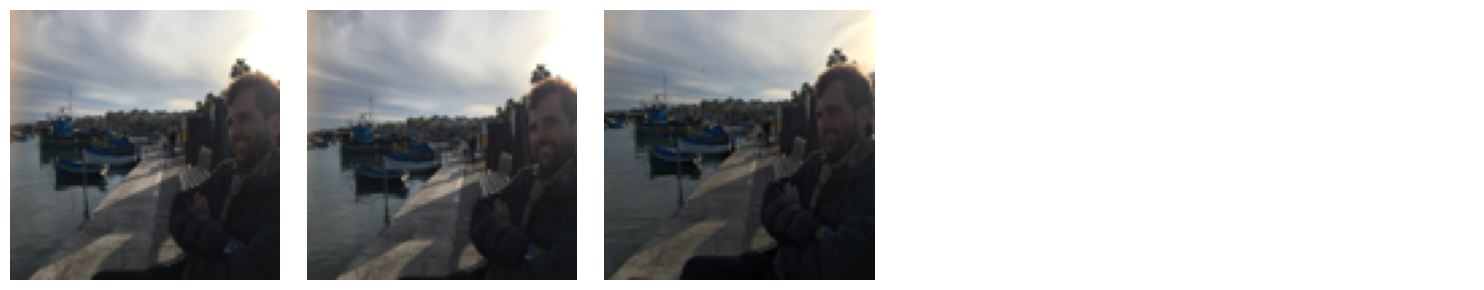


Кластер 2 (4 изображений):


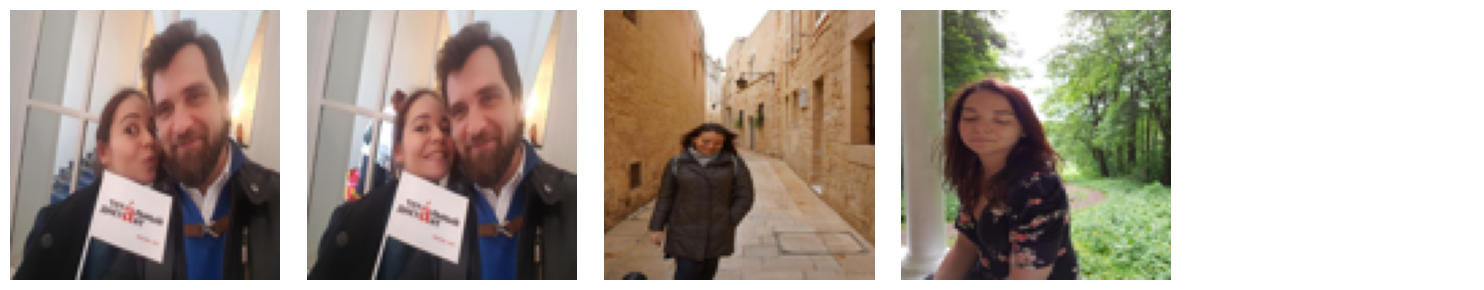


Кластер 1 (1 изображений):


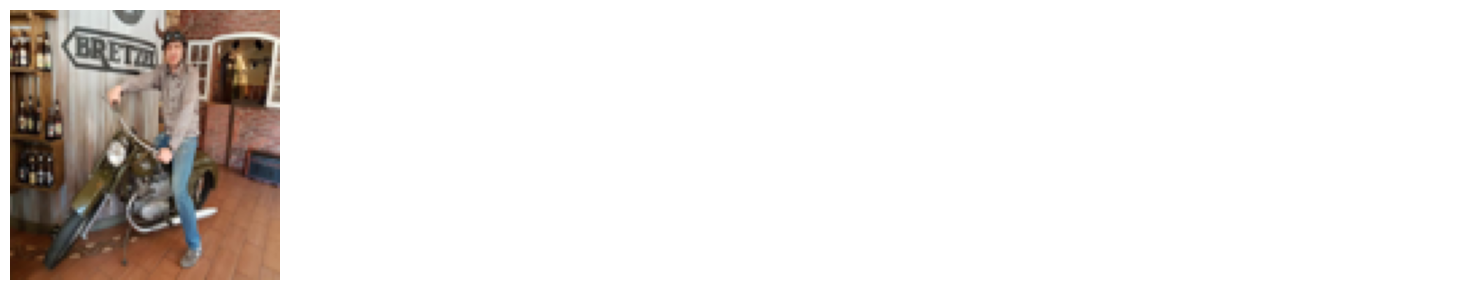

In [70]:
import os
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Настройка модели ---
def load_model():
    """Загрузка модели ResNet50 без верхнего слоя"""
    model = models.resnet50(pretrained=True)
    # Удаляем финальный fully connected слой
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    
    # Переводим модель в режим инференса и на GPU (если доступно)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    feature_extractor.to(device)
    feature_extractor.eval()
    return feature_extractor, device

# --- Извлечение признаков из изображения ---
def extract_pyramid_features(img_path, model, device, levels=[1, 2, 4]):
    """Извлекает признаки из изображения с использованием пирамиды уровней"""
    # Загрузка и предобработка изображения
    img = Image.open(img_path).convert('RGB')
    
    # Преобразования для входного изображения
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Оригинальные размеры изображения
    original_width, original_height = img.size
    
    features = []
    for level in levels:
        # Рассчитываем размеры масштабирования
        scale = original_width // level
        resized_size = (scale * level, scale * level)
        
        # Масштабирование изображения
        resized_img = transforms.Resize(resized_size)(img)
        
        for y in range(level):
            for x in range(level):
                # Обрезка региона
                left = x * scale
                upper = y * scale
                right = left + scale
                lower = upper + scale
                
                # Вырезаем область из изображения
                cropped_img = resized_img.crop((left, upper, right, lower))
                
                # Преобразуем в тензор и добавляем батч
                img_tensor = transform(cropped_img).unsqueeze(0).to(device)
                
                # Извлечение признаков
                with torch.no_grad():
                    crop_features = model(img_tensor).cpu().numpy().flatten()
                    features.append(crop_features)
    
    # Объединение всех признаков
    final_features = np.concatenate(features)
    return final_features

# --- Обработка папки ---
def get_features_from_folder(folder_path, model, device):
    features_list = []
    image_paths = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(folder_path, filename)
            try:
                features = extract_pyramid_features(path, model, device)
                features_list.append(features)
                image_paths.append(path)
            except Exception as e:
                print(f"Ошибка при обработке {path}: {e}")
    return np.array(features_list), image_paths

# --- Отображение кластеров ---
def display_clustered_images(clustered_images, images_per_row=5):
    for cluster_id, images in clustered_images.items():
        print(f"\nКластер {cluster_id} ({len(images)} изображений):")
        num_rows = (len(images) + images_per_row - 1) // images_per_row
        fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row*3, num_rows*3))
        
        # Приводим axes к 1D-массиву для удобства
        axes_flat = axes.ravel() if num_rows > 1 or images_per_row > 1 else [axes]
        
        for ax, img_path in zip(axes_flat, images):
            thumbnail = Image.open(img_path).convert('RGB').resize((100, 100))
            ax.imshow(thumbnail)
            ax.axis("off")
            
        # Скрываем пустые ячейки
        for ax in axes_flat[len(images):]:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

# --- Основной код ---
if __name__ == "__main__":
    # Загрузка модели
    feature_extractor, device = load_model()
    
    # Путь к папке с изображениями
    project_dir = "/root/projects/study_projects/MUIV/cv_course"
    folder_path = f"{project_dir}/data/plibrary/justfaces"
    
    # Извлечение признаков из всех изображений
    features_list, image_paths = get_features_from_folder(folder_path, feature_extractor, device)
    
    # Квантование признаков
    num_clusters = 3
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(features_list)
    labels = kmeans.labels_
    
    # Группировка изображений по кластерам
    clustered_images = {}
    for idx, label in enumerate(labels):
        clustered_images.setdefault(label, []).append(image_paths[idx])
    
    # Отображение результатов
    display_clustered_images(clustered_images)


/root/.venv/cv_course/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.venv/cv_course/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Кластер 0 (3 изображений):


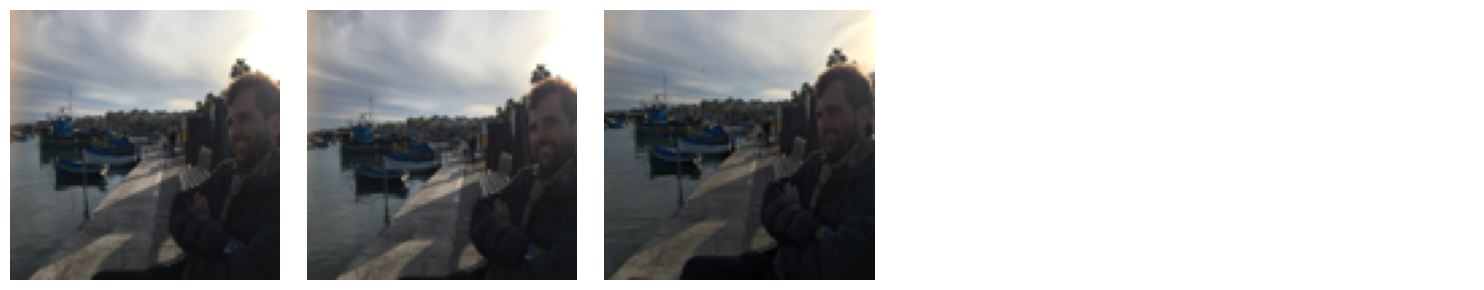


Кластер 2 (3 изображений):


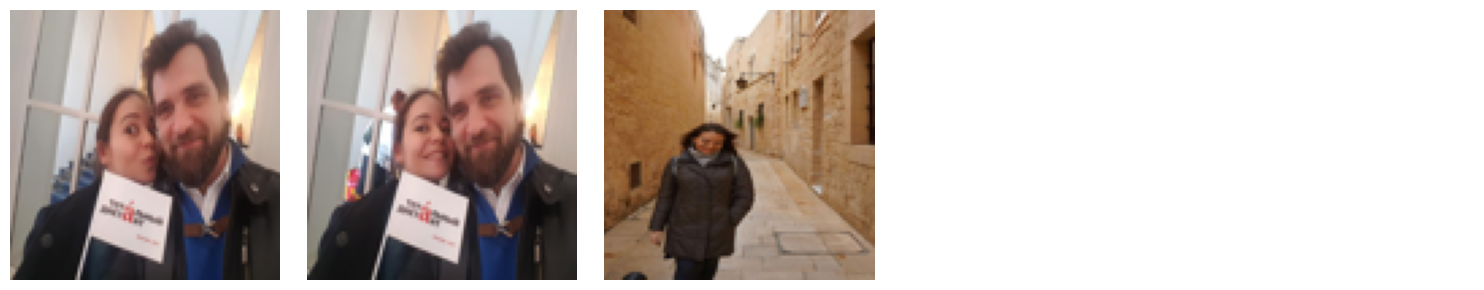


Кластер 1 (1 изображений):


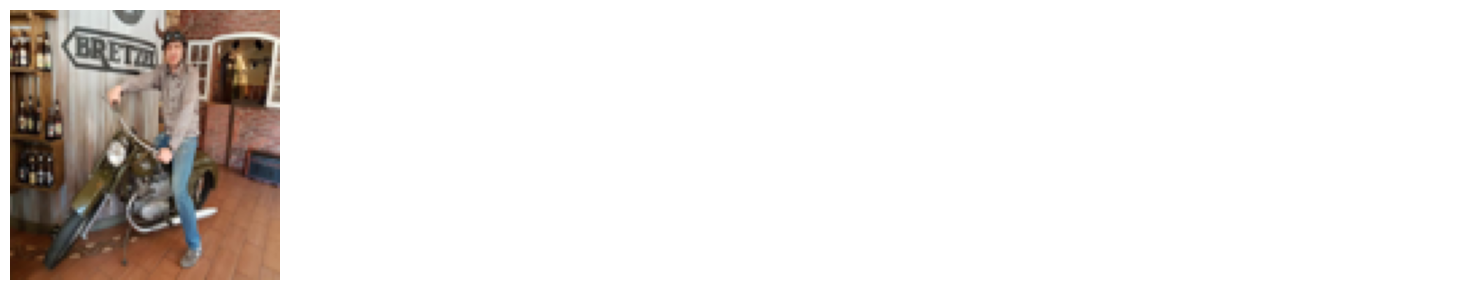


Кластер 3 (1 изображений):


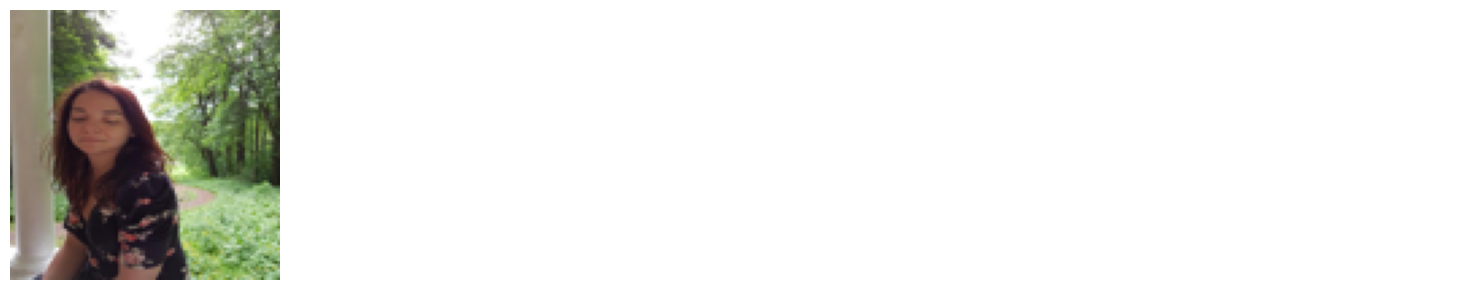

In [71]:


# --- Основной код ---
if __name__ == "__main__":
    # Загрузка модели
    feature_extractor, device = load_model()
    
    # Путь к папке с изображениями
    project_dir = "/root/projects/study_projects/MUIV/cv_course"
    folder_path = f"{project_dir}/data/plibrary/justfaces"
    
    # Извлечение признаков из всех изображений
    features_list, image_paths = get_features_from_folder(folder_path, feature_extractor, device)
    
    # Квантование признаков
    num_clusters = 4
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(features_list)
    labels = kmeans.labels_
    
    # Группировка изображений по кластерам
    clustered_images = {}
    for idx, label in enumerate(labels):
        clustered_images.setdefault(label, []).append(image_paths[idx])
    
    # Отображение результатов
    display_clustered_images(clustered_images)


# Работа с векторной БД


## ✅ Создание Annoy-индекса

In [72]:
import os
from annoy import AnnoyIndex
import numpy as np

# Пути
project_dir = "/root/projects/study_projects/MUIV/cv_course"
index_file = os.path.join("/root", "image_features.ann")

# Загрузка модели и извлечение признаков (пример)
def extract_pyramid_features(img_path):
    return np.random.rand(4096)  # Замените на реальную реализацию

# Создание индекса
features_list = [extract_pyramid_features(f"{project_dir}/data/faces/face_{i}.jpg") for i in range(10)]
feature_dim = features_list[0].shape[0]  # Убедитесь, что все векторы имеют одинаковую размерность

index = AnnoyIndex(feature_dim, "euclidean")
for i, features in enumerate(features_list):
    index.add_item(i, features)
index.build(10)  # 10 деревьев

# Сохранение индекса
index.save(index_file)
print(f"Индекс сохранён в {index_file} (размер: {os.path.getsize(index_file)} байт)")


Индекс сохранён в /root/image_features.ann (размер: 492000 байт)


## ✅ Поиск ближайших соседей

Ближайшие индексы: [0, 7, 1, 5, 9]


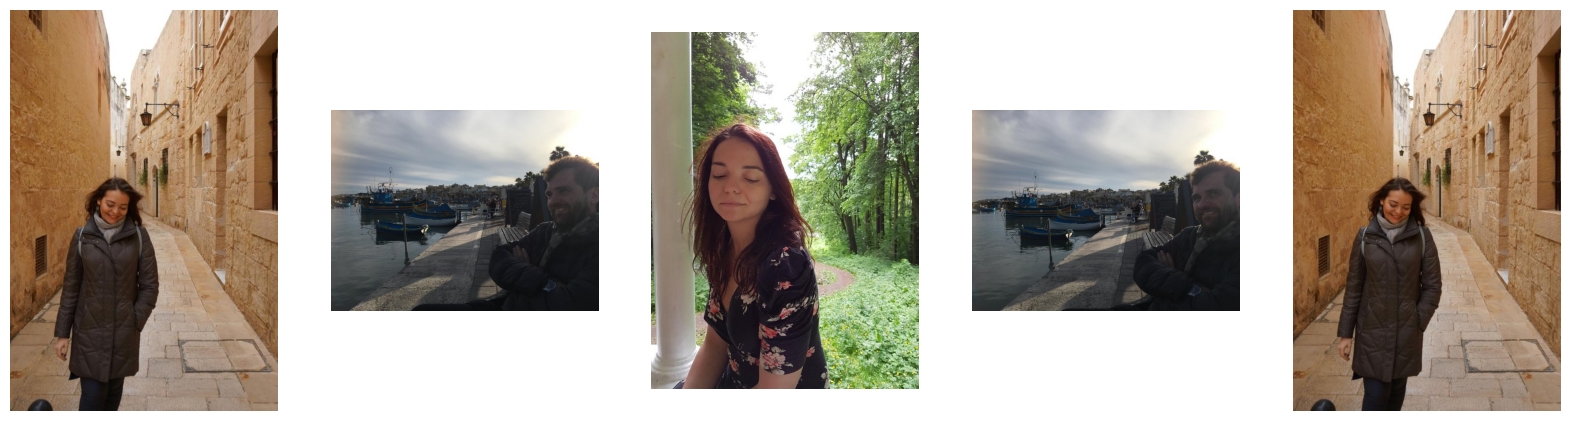

In [73]:
# Загрузка индекса
index = AnnoyIndex(feature_dim, "euclidean")  # Та же размерность и метрика
index.load(index_file)

# Извлечение признаков целевого изображения
target_features = extract_pyramid_features(f"{project_dir}./data/plibrary/justfaces/img_06.jpg")

# Поиск ближайших соседей
nearest_ids = index.get_nns_by_vector(target_features, 5)
print("Ближайшие индексы:", nearest_ids)
folder_path = "/root/projects/study_projects/MUIV/cv_course/data/plibrary/justfaces"
images_paths =[]
for img_name in os.listdir(folder_path):
    if img_name.lower().endswith(("png", "jpg", "jpeg")):

        images_paths.append(os.path.join(folder_path, img_name))
# Получение путей к ближайшим изображениям
#nearest_image_paths = [images_paths[i] for i in nearest_ids]
# Получение путей к изображениям
nearest_image_paths = [image_paths[i] for i in nearest_ids if i < len(image_paths)]

# Отображение результатов
def display_images(image_paths):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(20, 10))
    for ax, img_path in zip(axes, image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
    plt.show()

display_images([target_path] + nearest_image_paths)